# Higgs Tweet - Preprocessing

### Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os, sys, datetime
import pandas as pd
import nbimporter

### Read Social Graph

In [2]:
"""Load complete unweighted social network graph"""

def load_social_graph():
    G = nx.read_edgelist("./Data/higgs-social_network.edgelist",
                     create_using=nx.MultiDiGraph(), nodetype=int, data=(("kind", str),))
    # Add Friendship label to each edge in the loaded graph
    nx.set_edge_attributes(G, "FR", "kind")
    return G

G = load_social_graph()
print("Graph loaded:")

Graph loaded:


In [4]:
"""Test Graph"""

print(len(G))
print(len(G.edges))
print(nx.__version__)

456626
14855842
2.0


### Read Action Log

In [5]:
"""Read action log into a pandas dataframe"""

def dateparse (timestamp):    
    return datetime.datetime.fromtimestamp(float(timestamp))

def read_log():
    log = pd.read_csv("./Data/higgs-activity_time.txt", delimiter=" ",
                      index_col="time", parse_dates=True, date_parser=dateparse)
    return log

log = read_log()
print(log.shape[0])
print(log.head())

563069
                      user1   user2 type
time                                    
2012-06-30 17:02:52  223789  213163   MT
2012-06-30 17:02:52  223789  213163   RE
2012-06-30 17:06:21  376989   50329   RT
2012-06-30 17:06:23   26375  168366   MT
2012-06-30 17:06:32  376989   13813   RT


### Add action edges to the graph

In [6]:
"""Add action edges to the social graph"""

def add_log_edges_to_social_graph(G, log):
    """
    Input is a MultiDiGraph, log is a pandas dataframe,
    Output is a MultiDiGraph with more edges
    """
    for date, action in log.iterrows():
        G.add_edge(action["user1"], action["user2"], kind=action["type"])
    return G


print(len(G.edges))
G = add_log_edges_to_social_graph(G, log)
print(len(G.edges))

14855842
15418911


### Print edge-types

In [7]:
def count_and_print_actions_in_graph(G):
    follow = 0
    retweet = 0
    mention = 0
    reply = 0

    for u, v, attributes in G.edges(data=True): 
        if "kind" in attributes:
            if attributes["kind"] == "RT":
                retweet += 1
            elif attributes["kind"] == "MT":
                mention += 1
            elif attributes["kind"] == "FR":
                follow += 1
            elif attributes["kind"] == "RE":
                reply += 1
            else:
                print("Whaaat!")
        else:
            #pass
            sys.exit("Whoa, stop!")
    print("The distribution over FR, RT, MT, RE is")
    print(follow, retweet, mention, reply)
    print("Total number of edges is")
    print(follow + retweet + mention + reply)
    print("(should be ={})".format(len(G.edges)))

count_and_print_actions_in_graph(G)

The distribution over FR, RT, MT, RE is
14855842 354930 171237 36902
Total number of edges is
15418911
(should be =15418911)


In [8]:
"""Create DiGraph (tar litt tid..)"""

def create_digraph(G):
    """
    G is a typed multidigraph. 
    Build a weighted digraph by combining parallel edges
    """
    kind_weights = {"RT" : 0.01, "RE" : 0.01, "RT" : 0.01, "MT" : 0.01, "FR" : 0.00}

    D = nx.DiGraph()
    D.add_nodes_from(G)
    nx.set_edge_attributes(D, 0.0, "weight")

    for u in G:
        for v in G.predecessors(u):
            edges = dict(G[v][u])
            weight = 0.0
            for edge in edges.values():
                kind = edge["kind"]
                weight += kind_weights[kind]
            weight = np.min((weight, 1.0))
            if weight != 0:
                D.add_edge(u, v, weight=weight)
    return D

print(len(G.nodes))
D = create_digraph(G)
print(len(G.nodes))
print(len(D.edges))

weights = list(nx.get_edge_attributes(D, "weight").values())

NameError: name 'G' is not defined

466545


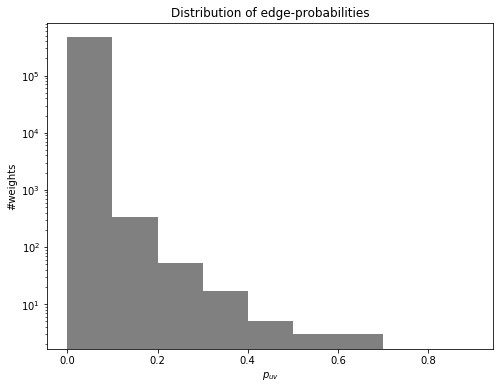

In [9]:
print(len(weights))
plt.figure(1, figsize=(8,6))
plt.hist(weights[:], bins=np.arange(0.0, 1.0, 0.1), color="gray")
plt.yscale('log', nonposy='clip')
plt.xlabel("$p_{uv}$")
plt.ylabel("#weights")
plt.title("Distribution of edge-probabilities")
plt.savefig("Report/Figures/puv_dist.png", bbox_inches="tight")
plt.show()

In [12]:
nx.write_weighted_edgelist(D, "Data/higggs-complete-graph.edgelist")

X = nx.read_weighted_edgelist("Data/higggs-complete-graph.edgelist")
print(len(X))
print(len(X.edges))

304691
454878


In [11]:
"""Useful functions"""

def sort_by_value(arr):
    return arr[np.argsort(-arr[:, 1])]

def get_top_k_indeg(G, k):
    _in =  np.array(G.in_degree()).astype(np.float)
    _in = sort_by_value(_in)
    return _in[0:k, 0]

def get_top_k_deg(G, k):
    _deg =  np.array(G.degree()).astype(np.float)
    _deg = sort_by_value(_deg)
    return _deg[0:k, 0]

def num_times_spread(log, u):
    log_counts = log["user2"].value_counts() #this is sorted
    if u in log_counts.index:
        return log_counts[u]
    else:
        return 0

def get_top_k_infl(log, k):
    log_counts = log["user2"].value_counts() #this is sorted
    users = np.array(log_counts.index, dtype=np.int)
    counts = np.array(log_counts.data, dtype=np.int)    
    return users[0:k]

def num_followers(G, u):
    return len(list(G.predecessors(u)))

def num_following(G, u):
    return len(list(G.successors(u)))

In [1]:
from load_higgs import DataFiles
DF = DataFiles()

in_out = [
    [DF.load_period_1_activity(), DF.out_period_1_activity], #only activity from period 1
    [DF.load_period_2_activity(), DF.out_period_2_activity], #only activity from period 2
    [DF.load_period_1_all(), DF.out_period_1_all],           #activity from period 1 and social network
    [DF.load_period_2_all(), DF.out_period_2_all],           #activity from period 2 and social network
    [DF.load_social(), DF.out_social],                       #only social network
    [DF.load_all(), DF.out_all]]                             #everything

# Writes the multigraphs
for graph, out_file in in_out:
    G = create_digraph(graph)
    nx.write_weighted_edgelist(G, out_file)

NameError: name 'create_digraph' is not defined

In [9]:
from main import celf
from load_higgs import DataFiles

DF = DataFiles()

k = 50
spread_iterations = 100

p1_activity = nx.read_weighted_edgelist(DF.out_period_1_activity, create_using=nx.MultiDiGraph())
nx.set_node_attributes(p1_activity, False, 'visited')
nx.set_node_attributes(p1_activity, 0, 'flag')
nx.set_node_attributes(p1_activity, 0, 'mg')

celf(p1_activity, k, spread_iterations) # This is very slow. Maybe better to run it locally using pypy3.

AttributeError: 'Graph' object has no attribute 'predecessors'